## mixtures e clustering

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import scipy as sc
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [4]:
def P(mu,s):
    c0 = (np.linalg.det(s)*(2*np.pi)**d)**-.5
    a = z - mu
    b = np.dot(np.linalg.inv(s) , a.T).T 
    c = np.multiply(a,b)
    r = np.sum(c, axis=1)
    return c0*np.exp(-.5*r)

def plot_ellipse(pos, cov, nstd=2, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, lw=1.5, **kwargs)
    ax.add_artist(ellip)
    return ellip 

In [5]:
rv0 = stats.multivariate_normal(mean=[2, 3], cov=[[.3, .3],[.3,.4]])
rv1 = stats.multivariate_normal(mean=[1.5, 1], cov=[[.5, -.5],[-.5,.7]])
rv2 = stats.multivariate_normal(mean=[0, 1.2], cov=[[.15, .1],[.1,.3]])
rv3 = stats.multivariate_normal(mean=[3.2, .3], cov=[[.2, 0],[0,.1]])

z0 = rv0.rvs(size=300)
z1 = rv1.rvs(size=300)
z2 = rv2.rvs(size=300)
z3 = rv3.rvs(size=300)

z=np.concatenate((z0, z1, z2, z3), axis=0)

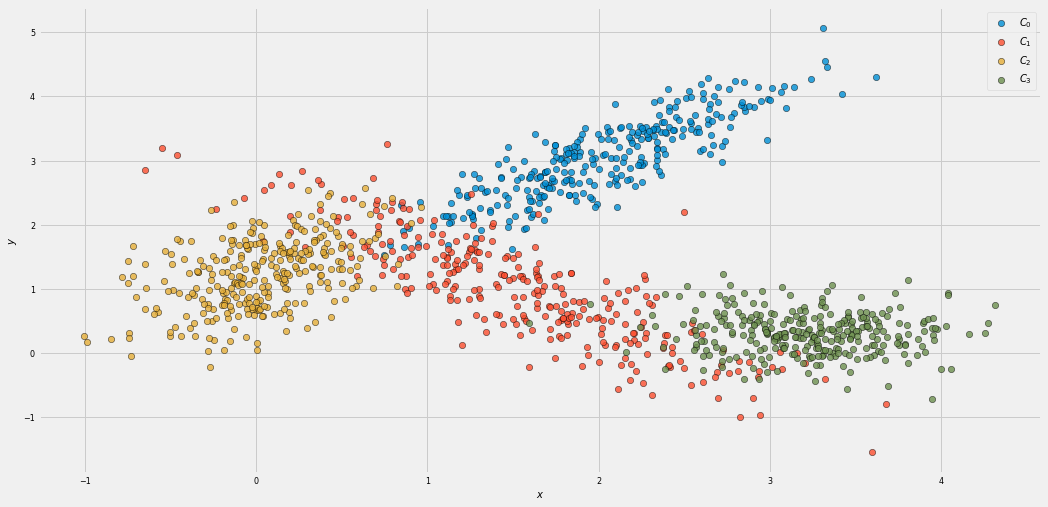

In [6]:
fig, ax = plt.subplots()
ax.scatter(z0[:,0], z0[:,1], s=40, color='C0', alpha =.8, edgecolors='k', label=r'$C_0$')
ax.scatter(z1[:,0], z1[:,1], s=40, color='C1', alpha =.8, edgecolors='k', label=r'$C_1$')
ax.scatter(z2[:,0], z2[:,1], s=40, color='C2', alpha =.8, edgecolors='k', label=r'$C_2$')
ax.scatter(z3[:,0], z3[:,1], s=40, color='C3', alpha =.8, edgecolors='k', label=r'$C_3$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

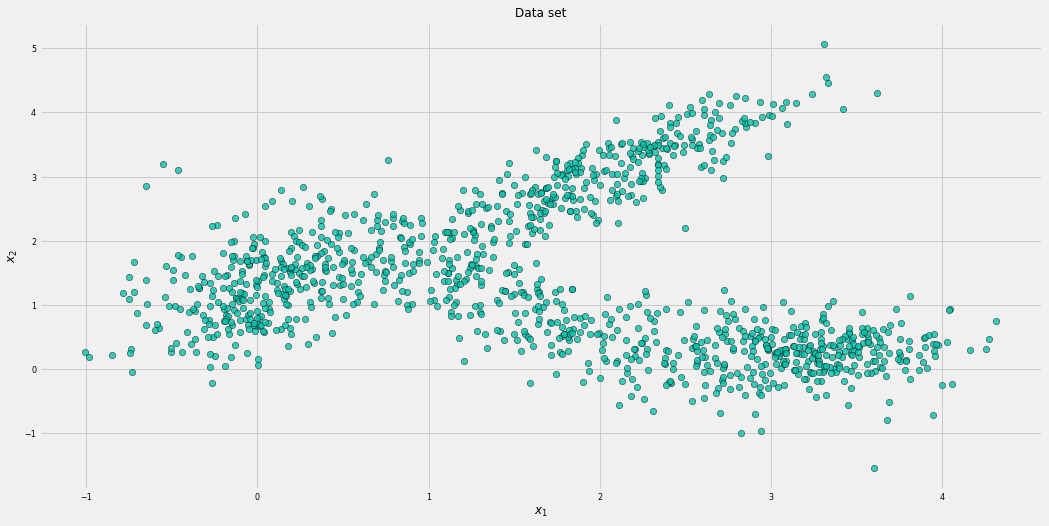

In [9]:
cc='xkcd:turquoise'
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(z[:,0], z[:,1], s=40, color=cc, edgecolors='k', alpha=.8)
plt.ylabel('$x_2$', fontsize=12)
plt.xlabel('$x_1$', fontsize=12)
plt.title('Data set', fontsize=12)
plt.show()

In [10]:
rgb0=mcolors.to_rgb('C0')
rgb1=mcolors.to_rgb('C1')
rgb2=mcolors.to_rgb('C2')
rgb3=mcolors.to_rgb('C3')

z0p=[rv0.pdf(x) for x in z]
z1p=[rv1.pdf(x) for x in z]
z2p=[rv2.pdf(x) for x in z]
z3p=[rv3.pdf(x) for x in z]

In [11]:
for i in range(len(z0p)):
    s = z0p[i]+z1p[i]+z2p[i]+z3p[i]
    z0p[i]=z0p[i]/s
    z1p[i]=z1p[i]/s
    z2p[i]=z2p[i]/s
    z3p[i]=z3p[i]/s
    
p=zip(z0p,z1p,z2p,z3p,z)

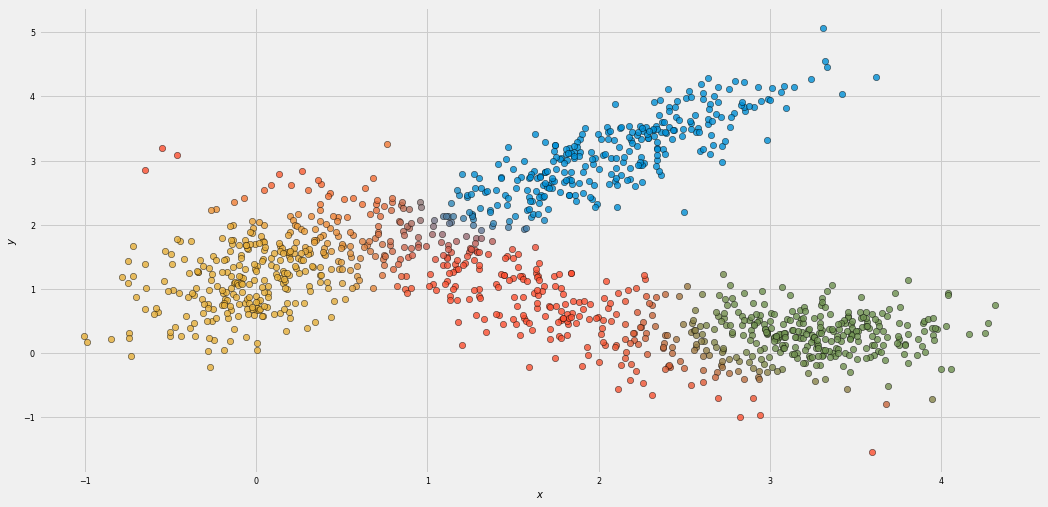

In [12]:
fig, ax = plt.subplots()
for pi in p:
    x0=rgb0[0]*pi[0]+rgb1[0]*pi[1]+rgb2[0]*pi[2]+rgb3[0]*pi[3]
    x1=rgb0[1]*pi[0]+rgb1[1]*pi[1]+rgb2[1]*pi[2]+rgb3[1]*pi[3]
    x2=rgb0[2]*pi[0]+rgb1[2]*pi[1]+rgb2[2]*pi[2]+rgb3[2]*pi[3]
    ax.scatter(pi[4][0], pi[4][1], s=40, color=(x0,x1,x2), edgecolors='k', alpha=.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [13]:
nc = 4        
n, d = z.shape
        
# randomly choose the starting centroids/means as 3 of the points from datasets        
mu = z[np.random.choice(n, nc, False), :]
# initialize the covariance matrices for each gaussians
Sigma= [np.eye(d)]*nc
        
# initialize the probabilities/weights for each gaussians
w = [1./nc]*nc
        
# responsibility matrix is initialized to all zeros
R = np.zeros((n, nc))
        
# log_likelihoods
log_likelihoods = []

E-step

In [14]:
for k in range(nc):
    R[:, k] = w[k] * P(mu[k], Sigma[k])
## Normalize so that the responsibility matrix is row stochastic
R = (R.T / np.sum(R, axis = 1)).T

### Likelihood computation
log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
log_likelihoods.append(log_likelihood)

## The number of datapoints belonging to each gaussian            
N_ks = np.sum(R, axis = 0)

In [15]:
p =zip(R[:,0], R[:,1], R[:,2], R[:,3], z)

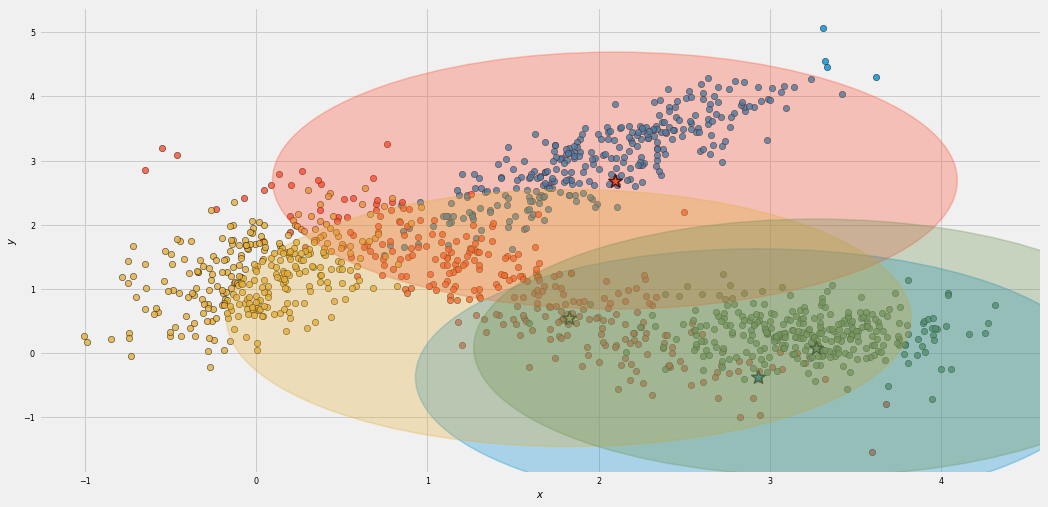

In [16]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(z0[:,0], z0[:,1], s=40, color='C0', alpha =.8, edgecolors='k', label=r'$C_0$')
ax.scatter(z1[:,0], z1[:,1], s=40, color='C1', alpha =.8, edgecolors='k', label=r'$C_1$')
ax.scatter(z2[:,0], z2[:,1], s=40, color='C2', alpha =.8, edgecolors='k', label=r'$C_2$')
ax.scatter(z3[:,0], z3[:,1], s=40, color='C3', alpha =.8, edgecolors='k', label=r'$C_3$')
for i in range(nc):
    plt.scatter(mu[i,0], mu[i,1], marker='*', s=200, color=colors[i], edgecolors='k', linewidth=1.5)
    plot_ellipse(mu[i], Sigma[i],  alpha=0.3, color = colors[i]) 
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

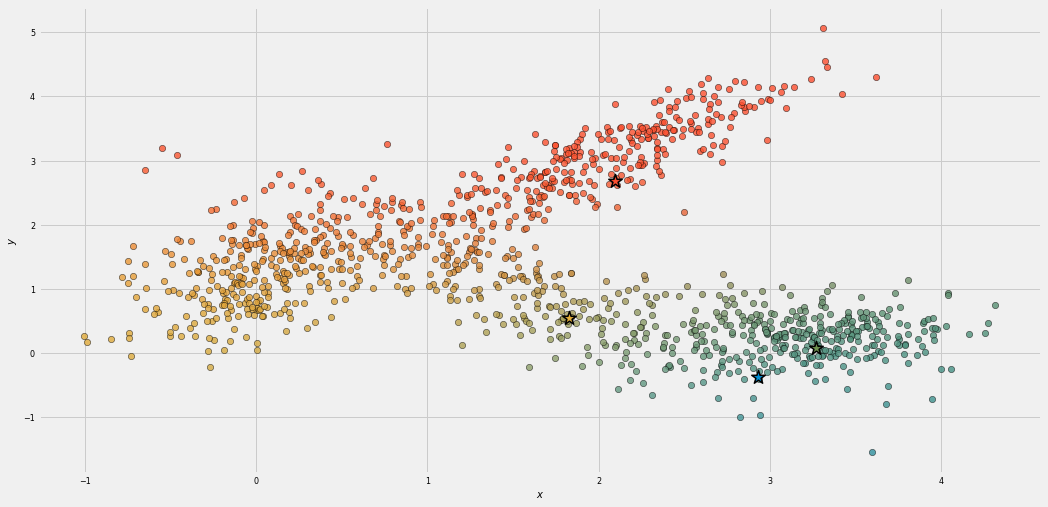

In [17]:
fig = plt.figure()
ax = plt.gca()
for pi in p:
    x0=rgb0[0]*pi[0]+rgb1[0]*pi[1]+rgb2[0]*pi[2]+rgb3[0]*pi[3]
    x1=rgb0[1]*pi[0]+rgb1[1]*pi[1]+rgb2[1]*pi[2]+rgb3[1]*pi[3]
    x2=rgb0[2]*pi[0]+rgb1[2]*pi[1]+rgb2[2]*pi[2]+rgb3[2]*pi[3]
    ax.scatter(pi[4][0], pi[4][1], s=40, color=(x0,x1,x2), edgecolors='k', alpha=.8)
for i in range(nc):
    plt.scatter(mu[i,0], mu[i,1], marker='*', s=200, color=colors[i], edgecolors='k', linewidth=1.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

M-step

In [18]:
for k in range(nc):
    ## means
    mu[k] = 1./N_ks[k]*np.sum(R[:, k]*z.T, axis = 1).T
    x_mu = np.matrix(z-mu[k])
    ## covariances
    Sigma[k] = np.array(1./N_ks[k]*np.dot(np.multiply(x_mu.T, R[:, k]), x_mu))
    ## and finally the probabilities
    w[k] = 1./n*N_ks[k]

In [19]:
for t in range(100):
    # E-step    
    for k in range(nc):
        R[:, k] = w[k] * P(mu[k], Sigma[k])
    ### Likelihood computation
    log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
    log_likelihoods.append(log_likelihood)
    ## Normalize so that the responsibility matrix is row stochastic
    R = (R.T / np.sum(R, axis = 1)).T
    ## The number of datapoints belonging to each gaussian            
    N_ks = np.sum(R, axis = 0)
    p =zip(R[:,0], R[:,1], R[:,2], R[:,3], z)
    for k in range(nc):
        ## means
        mu[k] = 1./N_ks[k]*np.sum(R[:, k]*z.T, axis = 1).T
        x_mu = np.matrix(z-mu[k])
        ## covariances
        Sigma[k] = np.array(1./N_ks[k]*np.dot(np.multiply(x_mu.T, R[:, k]), x_mu))
        ## and finally the probabilities
        w[k] = 1./n*N_ks[k]

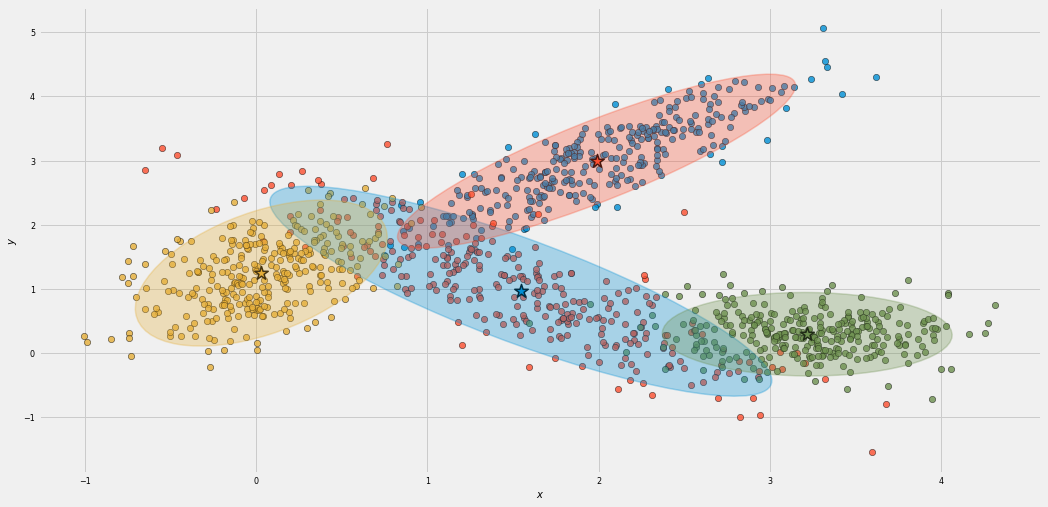

In [20]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(z0[:,0], z0[:,1], s=40, color='C0', alpha =.8, edgecolors='k', label=r'$C_0$')
ax.scatter(z1[:,0], z1[:,1], s=40, color='C1', alpha =.8, edgecolors='k', label=r'$C_1$')
ax.scatter(z2[:,0], z2[:,1], s=40, color='C2', alpha =.8, edgecolors='k', label=r'$C_2$')
ax.scatter(z3[:,0], z3[:,1], s=40, color='C3', alpha =.8, edgecolors='k', label=r'$C_3$')
for i in range(nc):
    plt.scatter(mu[i,0], mu[i,1], marker='*', s=200, color=colors[i], edgecolors='k', linewidth=1.5)
    plot_ellipse(mu[i], Sigma[i],  alpha=0.3, color = colors[i]) 
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

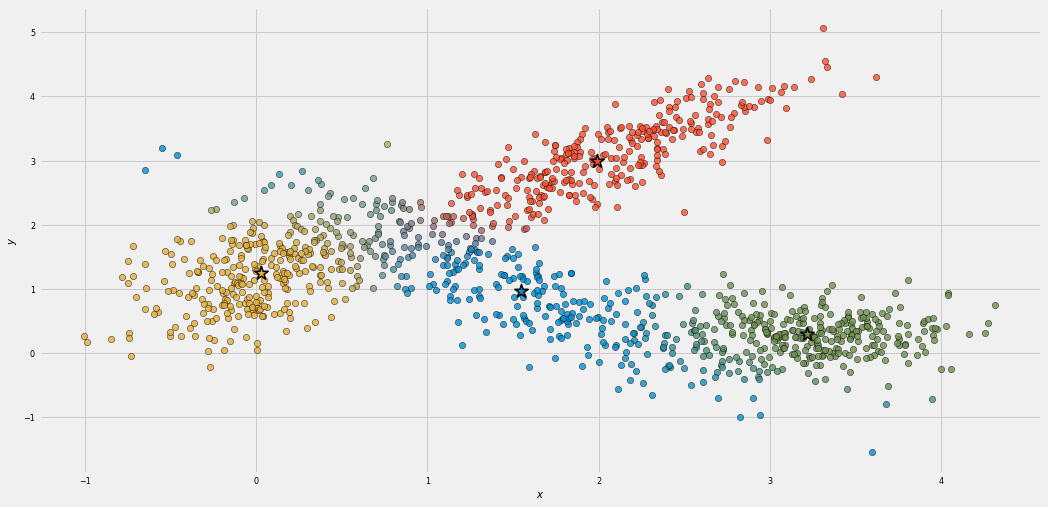

In [21]:
fig = plt.figure()
ax = plt.gca()
for pi in p:
    x0=rgb0[0]*pi[0]+rgb1[0]*pi[1]+rgb2[0]*pi[2]+rgb3[0]*pi[3]
    x1=rgb0[1]*pi[0]+rgb1[1]*pi[1]+rgb2[1]*pi[2]+rgb3[1]*pi[3]
    x2=rgb0[2]*pi[0]+rgb1[2]*pi[1]+rgb2[2]*pi[2]+rgb3[2]*pi[3]
    ax.scatter(pi[4][0], pi[4][1], s=40, color=(x0,x1,x2), edgecolors='k', alpha=.8)
for i in range(nc):
    plt.scatter(mu[i,0], mu[i,1], marker='*', s=200, color=colors[i], edgecolors='k', linewidth=1.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

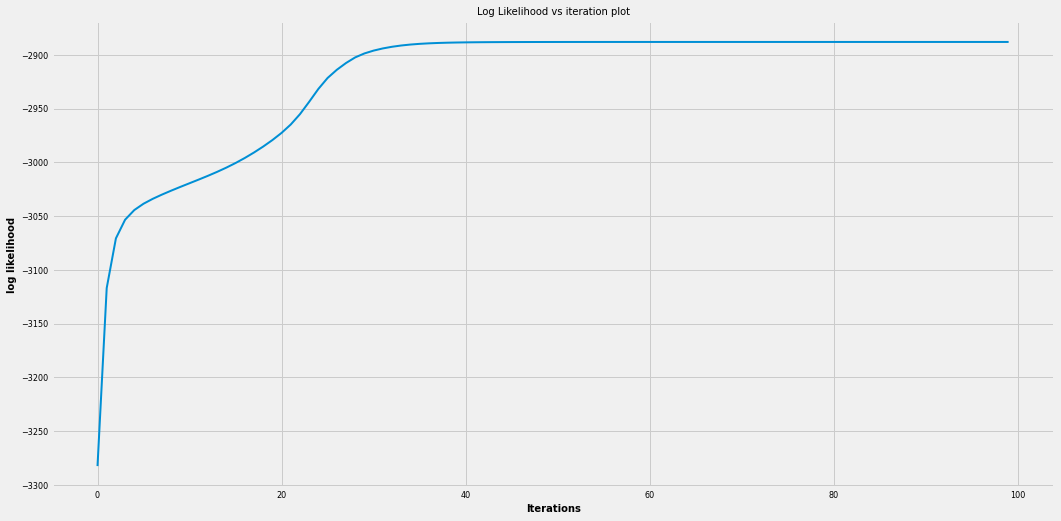

In [23]:
fig = plt.figure()
ax = plt.gca()
plt.plot(np.array(log_likelihoods)[1:])
plt.title('Log Likelihood vs iteration plot')
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.show()